#  Sentiment Analysis - Google Play Store Reviews




Skema:
1-3. Deep Learning: BiLSTM, CNN, Focal Loss
4-6. Machine Learning: SVM, Random Forest, Naive Bayes
7. Transformer: IndoBERT

Target akurasi: ≥3 schemes with ≥85% accuracy

## 0. Setup

In [ ]:
# !pip install -q Sastrawi imbalanced-learn transformers

import os, re, string, json, pickle, random, warnings, gc
import numpy as np
import pandas as pd
warnings.filterwarnings('ignore')

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt
import seaborn as sns

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(" GPU:", len(gpus))
else:
    print(" CPU mode")
print("TF:", tf.__version__)

    209.7/209.7 kB 4.4 MB/s eta 0:00:00


2026-01-23 19:32:42.634819: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769196762.821297      25 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769196762.872632      25 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769196763.324314      25 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769196763.324354      25 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769196763.324356      25 computation_placer.cc:177] computation placer alr

 GPU: 2
TF: 2.19.0


## 1. Load Data

In [2]:
DATA_PATH = "/kaggle/input/playstore-5/playstore_reviews.csv"
df = pd.read_csv(DATA_PATH)
print(f"Shape: {df.shape}")
df.head()

Shape: (146252, 8)


,review_id,username,review_text,rating,date,reply,app_version,helpful_count
0,6c2328a7-88cf-43dd-b091-2d8abdf7f839,Pengguna Google,ngapa si mau buka belanja online malah kebuka ...,2,2026-01-19 18:32:21,NaN,11.7.2,0
1,6a588f86-d1b3-4ec8-9c7c-833fdd4953c5,Pengguna Google,lelet,1,2026-01-19 06:49:15,NaN,11.7.2,0
2,6944b03e-dd44-47d1-b0ed-050113d23aa7,Pengguna Google,apakah buka emas masih ada,5,2026-01-19 06:15:21,NaN,NaN,0
3,d3bbaf59-3fce-48e0-8125-2a083ba04ba9,Pengguna Google,iya bener maaf tapi saya mau bilang yg sejujur...,1,2026-01-19 02:44:01,NaN,NaN,0
4,4f2c3919-011c-4917-bceb-6a05524ae0a1,Pengguna Google,tutup tokonya,1,2026-01-16 16:43:58,NaN,NaN,0


## 2. Option B: Auto-Label with Pre-trained Model

**Use this if:**
- You DON'T have rating column, OR
- Your rating column is **unreliable/noisy** (users give wrong ratings)

This will **re-label** based on actual text content, not user ratings.

Uncomment the code below:

## 2. Option B: Auto-Label with Pre-trained Model

**Use this if you DON'T have rating column**

Uncomment the code below to use IndoBERT for automatic sentiment labeling:

In [3]:
# OPTION B: Auto-label with pre-trained model
# Uncomment below if you DON'T have rating column:

# from transformers import pipeline
# import torch
# 
# print("Loading pre-trained sentiment classifier...")
# 
# # Option 1: Multilingual BERT (supports Indonesian)
# classifier = pipeline(
#     "sentiment-analysis",
#     model="nlptown/bert-base-multilingual-uncased-sentiment",
#     device=0 if torch.cuda.is_available() else -1
# )
# 
# # Clean basic data first
# df = df.dropna(subset=["review_text"])
# df["review_text"] = df["review_text"].astype(str)
# df = df[df["review_text"].str.strip() != ""]
# 
# print(f"\nLabeling {len(df)} reviews with pre-trained model...")
# print("This may take a few minutes...")
# 
# def label_with_pretrained(text):
#     """Label sentiment using pre-trained model"""
#     try:
#         # Truncate long text
#         text = text[:512]
#         result = classifier(text)[0]
#         
#         # Multilingual model returns 1-5 stars
#         label = result['label']
#         stars = int(label.split()[0]) if 'star' in label else 3
#         
#         # Convert to sentiment (same logic as rating)
#         if stars <= 2:
#             return 0  # Negatif
#         elif stars == 3:
#             return 1  # Netral
#         else:
#             return 2  # Positif
#     except:
#         return 1  # Default to Netral if error
# 
# # Label in batches for efficiency
# batch_size = 100
# sentiments = []
# 
# for i in range(0, len(df), batch_size):
#     batch = df.iloc[i:i+batch_size]
#     batch_sentiments = batch['review_text'].apply(label_with_pretrained)
#     sentiments.extend(batch_sentiments.tolist())
#     
#     if (i+batch_size) % 1000 == 0:
#         print(f"  Processed {i+batch_size}/{len(df)} reviews...")
# 
# df['sentiment'] = sentiments
# label_map = {0: "Negatif", 1: "Netral", 2: "Positif"}
# df['sentiment_label'] = df['sentiment'].map(label_map)
# 
# print("\n Labeling complete!")
# print("\nLabel distribution:")
# print(df['sentiment_label'].value_counts())
# 
# # Show sample
# print("\nSample labeled data:")
# print(df[['review_text', 'sentiment_label']].head(10))


### Compare: Rating vs Pre-trained Labels

**Optional:** If you want to see how different rating-based labels are from pre-trained labels:

In [4]:
# OPTIONAL: Compare rating-based vs pre-trained labels
# Uncomment to see the difference:

# import matplotlib.pyplot as plt
# import seaborn as sns
# 
# # Create rating-based labels (old way)
# def rating_to_sentiment(r):
#     if r <= 2: return 'Negatif'
#     if r == 3: return 'Netral'
#     return 'Positif'
# 
# if 'rating' in df.columns:
#     df['sentiment_rating'] = df['rating'].apply(rating_to_sentiment)
#     df['sentiment_pretrained'] = df['sentiment_label']  # From pre-trained
#     
#     # Confusion matrix: Rating vs Pre-trained
#     from sklearn.metrics import confusion_matrix
#     cm = confusion_matrix(
#         df['sentiment_rating'], 
#         df['sentiment_pretrained'],
#         labels=['Negatif', 'Netral', 'Positif']
#     )
#     
#     plt.figure(figsize=(10, 8))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn',
#                 xticklabels=['Negatif', 'Netral', 'Positif'],
#                 yticklabels=['Negatif', 'Netral', 'Positif'])
#     plt.xlabel('Pre-trained Label (Actual Text Content)')
#     plt.ylabel('Rating-based Label (User Rating)')
#     plt.title('Comparison: User Ratings vs Pre-trained Model\n(Shows how many users give wrong ratings!)')
#     plt.tight_layout()
#     plt.show()
#     
#     # Calculate disagreement
#     disagreement = (df['sentiment_rating'] != df['sentiment_pretrained']).sum()
#     disagreement_pct = disagreement / len(df) * 100
#     
#     print(f"\n{'='*80}")
#     print("COMPARISON RESULTS")
#     print(f"{'='*80}")
#     print(f"Total reviews: {len(df):,}")
#     print(f"Disagreement: {disagreement:,} ({disagreement_pct:.1f}%)")
#     print(f"Agreement: {len(df)-disagreement:,} ({100-disagreement_pct:.1f}%)")
#     print(f"\n {disagreement_pct:.1f}% of users gave ratings that don't match text content!")
#     
#     # Show examples of disagreement
#     print(f"\n{'='*80}")
#     print("EXAMPLES OF RATING MISMATCH (User gave wrong rating):")
#     print(f"{'='*80}")
#     
#     mismatched = df[df['sentiment_rating'] != df['sentiment_pretrained']].head(10)
#     for idx, row in mismatched.iterrows():
#         print(f"\nText: {row['review_text'][:100]}...")
#         print(f"  User gave:  {row['rating']} → {row['sentiment_rating']}")
#         print(f"  Should be:  {row['sentiment_pretrained']} (based on text content)")
#     
#     print(f"\n{'='*80}")
#     print("RECOMMENDATION:")
#     print(f"{'='*80}")
#     if disagreement_pct > 30:
#         print(" HIGH disagreement (>30%)!")
#         print("   → Use pre-trained labels instead of ratings")
#         print("   → Users are giving inconsistent/wrong ratings")
#     elif disagreement_pct > 15:
#         print(" MODERATE disagreement (15-30%)")
#         print("   → Consider using pre-trained labels")
#         print("   → Or use both for training (ensemble)")
#     else:
#         print(" LOW disagreement (<15%)")
#         print("   → Ratings are mostly reliable")
#         print("   → Can use rating-based labels")
# else:
#     print("No rating column found - using pre-trained labels")


### Metode Lexicon-Based




Menggunakan kamus kata positif/negatif (setelah stemming)
Menghitung kata positif vs negatif
Menangani negasi
Menangani intensifier





### Metode Hybrid Rating + Text

Kombinasi label dari rating dan analisis teks

Langkah:
1. Label awal dari rating
2. Analisis sentimen teks
3. Jika konflik, gunakan hasil teks
4. Jika sama, label confidence tinggi



In [5]:
# OPTION C: Hybrid (Rating + Text) - RECOMMENDED when ratings are unreliable!
# Uncomment below:

# from transformers import pipeline
# import torch
# 
# print(" Hybrid Labeling: Validating ratings with text analysis...")
# print("This catches inconsistencies like '1 star + positive text' or '5 stars + negative text'\n")
# 
# # Load classifier
# classifier = pipeline(
#     "sentiment-analysis",
#     model="nlptown/bert-base-multilingual-uncased-sentiment",
#     device=0 if torch.cuda.is_available() else -1
# )
# 
# # Clean data
# df = df.dropna(subset=["review_text", "rating"])
# df["review_text"] = df["review_text"].astype(str)
# df = df[df["review_text"].str.strip() != ""]
# df["rating"] = pd.to_numeric(df["rating"], errors="coerce")
# df = df.dropna(subset=["rating"])
# df["rating"] = df["rating"].astype(int)
# 
# # Get rating-based labels
# def rating_to_sentiment(r):
#     if r <= 2: return 0  # Negatif
#     if r == 3: return 1  # Netral
#     return 2  # Positif
# 
# df['rating_sentiment'] = df['rating'].apply(rating_to_sentiment)
# 
# # Get text-based labels
# def analyze_text(text):
#     try:
#         text = text[:512]
#         result = classifier(text)[0]
#         label = result['label']
#         confidence = result['score']
#         stars = int(label.split()[0]) if 'star' in label else 3
#         
#         if stars <= 2:
#             return 0, confidence  # Negatif
#         elif stars == 3:
#             return 1, confidence  # Netral
#         else:
#             return 2, confidence  # Positif
#     except:
#         return 1, 0.5  # Netral with low confidence
# 
# print(f"Analyzing {len(df)} reviews...")
# text_results = []
# batch_size = 100
# 
# for i in range(0, len(df), batch_size):
#     batch = df.iloc[i:i+batch_size]
#     for text in batch['review_text']:
#         text_results.append(analyze_text(text))
#     
#     if (i+batch_size) % 1000 == 0:
#         print(f"  Processed {i+batch_size}/{len(df)}...")
# 
# df['text_sentiment'] = [r[0] for r in text_results]
# df['text_confidence'] = [r[1] for r in text_results]
# 
# # Hybrid decision: Trust text when confident, use rating otherwise
# def hybrid_label(row):
#     rating_sent = row['rating_sentiment']
#     text_sent = row['text_sentiment']
#     confidence = row['text_confidence']
#     
#     # If text is very confident (>0.8), trust it
#     if confidence > 0.8:
#         return text_sent
#     
#     # If they agree, definitely use it
#     if rating_sent == text_sent:
#         return rating_sent
#     
#     # If they conflict but text is confident, trust text
#     if confidence > 0.6:
#         return text_sent
#     
#     # Otherwise use rating as fallback
#     return rating_sent
# 
# df['sentiment'] = df.apply(hybrid_label, axis=1)
# label_map = {0: "Negatif", 1: "Netral", 2: "Positif"}
# df['sentiment_label'] = df['sentiment'].map(label_map)
# 
# # Show statistics
# print("\n" + "="*80)
# print("HYBRID LABELING RESULTS")
# print("="*80)
# 
# # Count agreements and conflicts
# df['agree'] = df['rating_sentiment'] == df['text_sentiment']
# agreements = df['agree'].sum()
# conflicts = len(df) - agreements
# 
# print(f"\n Agreement Analysis:")
# print(f"   Rating & Text AGREE:    {agreements:,} ({agreements/len(df)*100:.1f}%)")
# print(f"    Rating & Text CONFLICT: {conflicts:,} ({conflicts/len(df)*100:.1f}%)")
# 
# print(f"\n Final Label Distribution:")
# print(df['sentiment_label'].value_counts())
# 
# # Show examples of conflicts (where we fixed bad ratings)
# print(f"\n Examples of Fixed Labels (Rating was wrong):")
# conflicts_df = df[~df['agree']].head(10)
# for idx, row in conflicts_df.iterrows():
#     rating_label = label_map[row['rating_sentiment']]
#     text_label = label_map[row['text_sentiment']]
#     final_label = row['sentiment_label']
#     print(f"\n  Rating: {row['rating']} → {rating_label:8s} | "
#           f"Text: {text_label:8s} | Final: {final_label:8s}")
#     print(f"  '{row['review_text'][:80]}...'")
# 
# print("\n" + "="*80)
# print(" Hybrid labeling complete! Labels are now more accurate.")
# print("="*80)


In [6]:
# LEXICON-BASED LABELING (Fast & Good Enough!)
# Uses word counting after stemming
# Uncomment below:

print("Using Lexicon-Based Labeling (Fast Method)...\n")

# Indonesian sentiment words (AFTER STEMMING by Sastrawi)
# These are STEM forms, not original words!
positive_stems = {
    # Core positive
    'bagus','baik','mantap','mantab','keren','hebat','luar','biasa',
    'sempurna','puas','terbaik','best','excellent','recommended',
    'rekomen','recommend','suka','senang','gembira','bahagia','cinta','mntap',
    
    # UX / performance
    'nyaman','lancar','cepat','mudah','gampang','praktis','efisien',
    'canggih','stabil','mulus','smooth','responsif','responsive',
    
    # Utility
    'guna','berguna','bantu','ngebantu','kepake','kepakai',
    'fungsi','fitur','lengkap','optimal','maksimal',
    
    # Slang & informal
    'oke','ok','top','jos','mantul','kece','asik','cakep','sip',
    'worth','worthit','value','layak','pantas',
    
    # Accuracy & trust
    'betul','benar','akurat','detail','jelas',
    'aman','safe','secure','secured','percaya','terpercaya',
    
    # Outcome
    'sukses','berhasil','jalan','normal','work','working',
    'happy','satisfied'
}

negative_stems = {
    # Core negative
    'jelek','buruk','parah','kecewa','zonk','sampah','ampas','najis',
    'busuk','rusak','hancur','payah','halah',
    
    # Technical / app failure
    'error','eror','bug','lemot','lambat','lelet','lag','ngelag',
    'macet','crash','force','close','freeze','stuck','loading',
    'ngadat','keluar','logout','putus','disconnect',
    
    # Cannot use
    'gabisa','gakbisa','nggakbisa','tidakbisa',
    'gaada','gakada','nggaada','nggakada','hilang','lenyap',
    
    # UX complaints
    'ribet','rumit','bingung','susah','sulit','berat','delay',
    'aneh','gajelas',
    
    # Monetization / policy
    'mahal','kemahalan','boros','bayar','berbayar','langganan',
    'subscription','dipaksa','iklan','ads','spam','popup',
    
    # Trust / fraud
    'salah','wrong','fake','palsu','bohong','tipu','scam',
    
    # Emotion
    'marah','kesal','sebel','emosi','kapok','nyesel',
    
    # Support
    'komplain','protes','refund','uang','money'
}

# Negation words (flip sentiment)
negations = {
    'tidak','bukan','jangan','belum','tak',
    'ga','gak','ngga','nggak',
    'gabisa','gakbisa','nggakbisa',
    'gaada','gakada','nggakada',
    'gausah','gaperlu'
}

# Intensifiers (amplify sentiment)
intensifiers = {
    'sangat', 'banget', 'sekali', 'amat', 'terlalu', 'paling', 
    'super', 'ultra', 'bener', 'sih', 'deh', 'nih'
}

# Complaint/Question phrases (indicate dissatisfaction)
complaint_phrases = {
    'kenapa', 'knapa', 'kok', 'masa', 'tolong',
    'udah gak', 'gak jual', 'nggak jual', 'tidak jual',
    'berubah', 'kembali', 'bangkit lagi'
}

def label_lexicon_stemmed(text):
    """Label using stemmed word counting with negation and context handling"""
    words = text.lower().split()  # Already cleaned & stemmed
    original_text = text.lower()  # Keep original for phrase detection
    
    pos_score = 0
    neg_score = 0
    
    # Check for complaint/question context (bias towards negative/neutral)
    has_complaint = any(phrase in original_text for phrase in complaint_phrases)
    if has_complaint:
        neg_score += 0.5  # Small negative bias for complaints/questions
    
    for i, word in enumerate(words):
        # Check for negation before word
        has_negation = (i > 0 and words[i-1] in negations)
        
        # Check for intensifier before word
        has_intensifier = (i > 0 and words[i-1] in intensifiers)
        multiplier = 2.0 if has_intensifier else 1.0
        
        if word in positive_stems:
            if has_negation:
                neg_score += multiplier  # "tidak bagus" = negative
            else:
                pos_score += multiplier
        
        elif word in negative_stems:
            if has_negation:
                pos_score += multiplier  # "tidak jelek" = positive
            else:
                neg_score += multiplier
    
    # Determine sentiment with stricter thresholds
    score = pos_score - neg_score
    
    # More strict thresholds to reduce false positives/negatives
    if score > 0.5:
        return 2  # Positif
    elif score < -0.5:
        return 0  # Negatif
    else:
        return 1  # Netral

# Clean data first
df = df.dropna(subset=["review_text"])
df["review_text"] = df["review_text"].astype(str)
df = df[df["review_text"].str.strip() != ""]

print(f"Labeling {len(df)} reviews with lexicon method...")
print("This uses cleaned & stemmed text for better accuracy\n")

# Label using CLEANED text (will be created in next cell)
# For now, we'll create cleaned text here
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import re
import string

stemmer = StemmerFactory().create_stemmer()
stopwords = set(StopWordRemoverFactory().get_stop_words())

def clean_text_for_lexicon(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|@\w+|#\w+|\d+", " ", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\s+", " ", text).strip()
    tokens = [t for t in text.split() if t not in stopwords and len(t) > 1]
    return stemmer.stem(" ".join(tokens))

print("Cleaning and stemming text...")
df['cleaned_temp'] = df['review_text'].apply(clean_text_for_lexicon)

print("Applying lexicon...")
df['sentiment'] = df['cleaned_temp'].apply(label_lexicon_stemmed)

label_map = {0: "Negatif", 1: "Netral", 2: "Positif"}
df['sentiment_label'] = df['sentiment'].map(label_map)

print("\n" + "="*80)
print("LEXICON LABELING RESULTS")
print("="*80)
print(f"\n Label Distribution:")
print(df['sentiment_label'].value_counts())
print(f"\nPositif: {(df['sentiment']==2).sum():,} ({(df['sentiment']==2).sum()/len(df)*100:.1f}%)")
print(f"Netral:  {(df['sentiment']==1).sum():,} ({(df['sentiment']==1).sum()/len(df)*100:.1f}%)")
print(f"Negatif: {(df['sentiment']==0).sum():,} ({(df['sentiment']==0).sum()/len(df)*100:.1f}%)")

# Show examples
print(f"\n Sample Labeled Reviews:")
print("="*80)
sample = df[['review_text', 'sentiment_label']].head(10)
for idx, row in sample.iterrows():
    print(f"\n{row['sentiment_label']:8s}: {row['review_text'][:100]}...")

# Validation: Check specific test cases
print("\n" + "="*80)
print(" VALIDATION: Checking Specific Test Cases")
print("="*80)

test_cases = [
    "lelet",
    "mntap bng",
    "Halah",
    "kenapa Bukalapak udah gak Terima jual beli barang fisik",
    "Bukalapak tolong kerjasama dengan Tokopedia",
    "aplikasi bagus sekali",
    "sangat kecewa dengan pelayanan",
    "biasa aja sih",
    "tidak bagus",
    "gak jelek kok"
]

for text in test_cases:
    cleaned = clean_text_for_lexicon(text)
    label = label_lexicon_stemmed(cleaned)
    print(f"\nOriginal: {text}")
    print(f"Cleaned : {cleaned}")
    print(f"Label   : {label_map[label]}")

print("\n" + "="*80)
print(" Lexicon labeling complete! Ready for preprocessing.")
print("="*80)

# Additional statistics
print("\n Additional Statistics:")
print("="*80)
print(f"Total reviews: {len(df):,}")
print(f"Average review length: {df['review_text'].str.len().mean():.1f} characters")
print(f"Average cleaned length: {df['cleaned_temp'].str.split().str.len().mean():.1f} words")

# Check for potential issues
neutral_pct = (df['sentiment']==1).sum()/len(df)*100
if neutral_pct > 50:
    print(f"\n  WARNING: High neutral percentage ({neutral_pct:.1f}%)")
    print("   Consider adjusting threshold or adding more lexicon terms")

if (df['sentiment']==2).sum() < (df['sentiment']==0).sum() * 0.3:
    print(f"\n  WARNING: Very low positive reviews")
    print("   This might indicate genuine user dissatisfaction or missing positive terms")

print("="*80)

Using Lexicon-Based Labeling (Fast Method)...

Labeling 146250 reviews with lexicon method...
This uses cleaned & stemmed text for better accuracy

Cleaning and stemming text...
Applying lexicon...

LEXICON LABELING RESULTS

 Label Distribution:
sentiment_label
Netral     61338
Positif    55556
Negatif    29356
Name: count, dtype: int64

Positif: 55,556 (38.0%)
Netral:  61,338 (41.9%)
Negatif: 29,356 (20.1%)

 Sample Labeled Reviews:

Positif : ngapa si mau buka belanja online malah kebuka voucher plsa dll .udh tau mau belanja brang ..kemana f...

Negatif : lelet...

Netral  : apakah buka emas masih ada...

Negatif : iya bener maaf tapi saya mau bilang yg sejujurnya knpa aplikasinya nggak jual barang2 kyak marketpla...

Netral  : tutup tokonya...

Netral  : kenapa Bukalapak udah gak Terima jual beli barang fisik semacam elektronik dan lainnya kenapa jadi p...

Positif : mntap bng...

Negatif : Halah...

Netral  : Bukalapak tolong kerjasama dengan Tokopedia, dan bangkit lagi seperti Buk

## 2. Option A: Clean & Label (Rating-Based)

**Use this if you have `rating` column (1-5 stars)**

In [7]:
# df = df.dropna(subset=["review_text", "rating"])
# df["review_text"] = df["review_text"].astype(str)
# df = df[df["review_text"].str.strip() != ""]
# df["rating"] = pd.to_numeric(df["rating"], errors="coerce")
# df = df.dropna(subset=["rating"]).astype({"rating": int})

# def rating_to_sentiment(r):
#     if r <= 2: return 0
#     if r == 3: return 1
#     return 2

# df["sentiment"] = df["rating"].apply(rating_to_sentiment)
# label_map = {0: "Negatif", 1: "Netral", 2: "Positif"}
# df["sentiment_label"] = df["sentiment"].map(label_map)
# print(df["sentiment_label"].value_counts())

## 3. Preprocess

In [8]:
stemmer = StemmerFactory().create_stemmer()
stopwords = set(StopWordRemoverFactory().get_stop_words())

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|@\w+|#\w+|\d+", " ", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\s+", " ", text).strip()
    tokens = [t for t in text.split() if t not in stopwords and len(t) > 1]
    return stemmer.stem(" ".join(tokens))

df["cleaned"] = df["review_text"].apply(clean_text)
df = df[df["cleaned"].str.strip() != ""]
df = df[df["cleaned"].str.split().str.len() >= 2]
print(f"Final: {df.shape}")

Final: (111865, 12)


## 4. Data Splits

In [9]:
MAX_WORDS, MAX_LEN = 20000, 120

# For DL
tokenizer_dl = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer_dl.fit_on_texts(df["cleaned"])
seqs = tokenizer_dl.texts_to_sequences(df["cleaned"])
X_dl = pad_sequences(seqs, maxlen=MAX_LEN, padding="post")
y = df["sentiment"].values
y_cat = to_categorical(y, 3)
vocab_size = min(len(tokenizer_dl.word_index) + 1, MAX_WORDS)

X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(
    X_dl, y_cat, test_size=0.2, random_state=SEED, stratify=y
)

# For ML
X_text, y_ml = df["cleaned"].values, df["sentiment"].values
X_train_text, X_test_text, y_train_ml, y_test_ml = train_test_split(
    X_text, y_ml, test_size=0.3, random_state=SEED, stratify=y_ml
)
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf = tfidf.transform(X_test_text)

print(f"DL: {X_train_dl.shape}, {X_test_dl.shape}")
print(f"ML: {X_train_tfidf.shape}, {X_test_tfidf.shape}")

DL: (89492, 120), (22373, 120)
ML: (78305, 10000), (33560, 10000)


## 5. Utils

In [10]:
def categorical_focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1-1e-7)
        ce = -y_true * tf.math.log(y_pred)
        return tf.reduce_sum(alpha * tf.pow(1-y_pred, gamma) * ce, axis=-1)
    return loss

def make_callbacks(prefix):
    return [
        EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True, mode="max", verbose=1),
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1),
        ModelCheckpoint(f"{prefix}.keras", monitor="val_accuracy", save_best_only=True, mode="max", verbose=0)
    ]

def plot_cm(y_true, y_pred, title):
    plt.figure(figsize=(6,5))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues",
                xticklabels=["Negatif","Netral","Positif"],
                yticklabels=["Negatif","Netral","Positif"])
    plt.title(title)
    plt.ylabel("True")
    plt.xlabel("Pred")
    plt.tight_layout()
    plt.show()

def evaluate(y_true, y_pred, name):
    acc = accuracy_score(y_true, y_pred)
    print(f"\n{'='*60}\n{name} - Acc: {acc:.4f} ({acc*100:.2f}%)\n{'='*60}")
    print(classification_report(y_true, y_pred, target_names=["Negatif","Netral","Positif"]))
    return acc

print(" Utils ready")

 Utils ready


## 6. Class Weights

In [11]:
y_train_int = np.argmax(y_train_dl, axis=1)
class_weights = compute_class_weight("balanced", classes=np.array([0,1,2]), y=y_train_int)
class_weights_dict = {i: w for i, w in enumerate(class_weights)}
print("Weights:", class_weights_dict)

Weights: {0: np.float64(1.2973803621392017), 1: np.float64(0.8493925588458618), 2: np.float64(0.950657021150026)}


---
##  SCHEME 7: IndoBERT

Device: cuda


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1:   0%|          | 1/500 [00:00<06:32,  1.27it/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Epoch 1: 100%|| 500/500 [01:37<00:00,  5.15it/s]


Epoch 1 Loss: 0.5306


Epoch 2: 100%|| 500/500 [01:48<00:00,  4.59it/s]


Epoch 2 Loss: 0.1868


Epoch 3: 100%|| 500/500 [01:48<00:00,  4.62it/s]


Epoch 3 Loss: 0.1315

Train Acc: 0.9708 (97.08%)

Scheme 7: IndoBERT - Acc: 0.9210 (92.10%)
              precision    recall  f1-score   support

     Negatif       0.92      0.92      0.92       302
      Netral       0.91      0.92      0.91       425
     Positif       0.94      0.93      0.94       273

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000



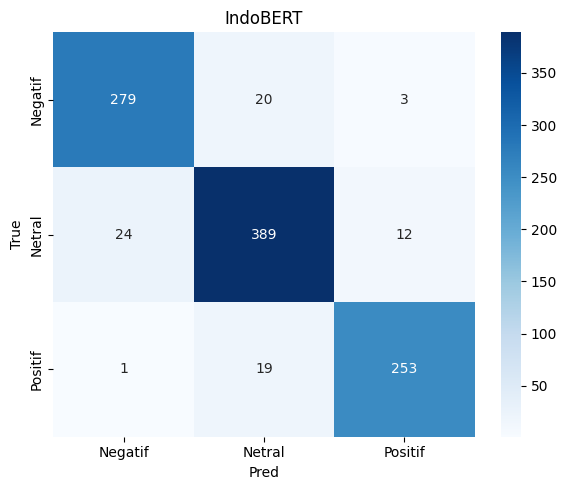

 Memory cleared


In [12]:
# OPTION: PyTorch IndoBERT (Recommended)
# Uncomment to test:

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# Clear memory
gc.collect()
torch.cuda.empty_cache()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

MODEL = "indobenchmark/indobert-base-p1"
tokenizer7 = AutoTokenizer.from_pretrained(MODEL)

# Small subset
subset = min(5000, len(X_text))
X_bert, y_bert = X_text[:subset], y_ml[:subset]
X_tr, X_te, y_tr, y_te = train_test_split(X_bert, y_bert, test_size=0.2, random_state=SEED, stratify=y_bert)

# Tokenize
train_enc = tokenizer7(X_tr.tolist(), padding='max_length', truncation=True, max_length=128, return_tensors="pt")
test_enc = tokenizer7(X_te.tolist(), padding='max_length', truncation=True, max_length=128, return_tensors="pt")

# Model
model7 = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=3).to(device)
train_data = TensorDataset(train_enc['input_ids'], train_enc['attention_mask'], torch.tensor(y_tr))
train_loader = DataLoader(train_data, batch_size=8, shuffle=True)

# Train
optimizer = torch.optim.AdamW(model7.parameters(), lr=2e-5)
model7.train()
for epoch in range(3):
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        ids, mask, labels = [b.to(device) for b in batch]
        optimizer.zero_grad()
        loss = model7(ids, attention_mask=mask, labels=labels).loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {total_loss/len(train_loader):.4f}")

# Evaluate (batched to avoid OOM)
model7.eval()
preds = []
with torch.no_grad():
    for i in range(0, len(test_enc['input_ids']), 32):
        batch_ids = test_enc['input_ids'][i:i+32].to(device)
        batch_mask = test_enc['attention_mask'][i:i+32].to(device)
        out = model7(batch_ids, attention_mask=batch_mask)
        preds.extend(torch.argmax(out.logits, dim=1).cpu().numpy())
y_pred7 = np.array(preds)

# Train accuracy
train_preds = []
with torch.no_grad():
    for i in range(0, len(train_enc['input_ids']), 32):
        batch_ids = train_enc['input_ids'][i:i+32].to(device)
        batch_mask = train_enc['attention_mask'][i:i+32].to(device)
        out = model7(batch_ids, attention_mask=batch_mask)
        preds_batch = torch.argmax(out.logits, dim=1).cpu().numpy()
        train_preds.extend(preds_batch)
train_pred7 = np.array(train_preds)
train_acc7 = accuracy_score(y_tr, train_pred7)
print(f"\nTrain Acc: {train_acc7:.4f} ({train_acc7*100:.2f}%)")


acc7 = evaluate(y_te, y_pred7, "Scheme 7: IndoBERT")
plot_cm(y_te, y_pred7, "IndoBERT")

# Cleanup
del model7
torch.cuda.empty_cache()
print(" Memory cleared")

---
##  SCHEMES 1-6: Core Models (Always Work!)


## Models

In [13]:
def build_bilstm(vocab, maxlen):
    inp = layers.Input(shape=(maxlen,))
    x = layers.Embedding(vocab, 128)(inp)
    x = layers.Bidirectional(layers.LSTM(64, dropout=0.25))(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(3, activation="softmax")(x)
    m = models.Model(inp, out)
    m.compile(optimizer=Adam(3e-4), loss="categorical_crossentropy", metrics=["accuracy"])
    return m

def build_cnn(vocab, maxlen):
    inp = layers.Input(shape=(maxlen,))
    x = layers.Embedding(vocab, 128)(inp)
    x = layers.Conv1D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv1D(128, 5, activation="relu", padding="same")(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.35)(x)
    out = layers.Dense(3, activation="softmax")(x)
    m = models.Model(inp, out)
    m.compile(optimizer=Adam(2e-4), loss="categorical_crossentropy", metrics=["accuracy"])
    return m

def build_focal(vocab, maxlen):
    inp = layers.Input(shape=(maxlen,))
    x = layers.Embedding(vocab, 128)(inp)
    x = layers.Bidirectional(layers.LSTM(96, dropout=0.2))(x)
    x = layers.Dense(96, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(3, activation="softmax")(x)
    m = models.Model(inp, out)
    m.compile(optimizer=Adam(2e-4), loss=categorical_focal_loss(), metrics=["accuracy"])
    return m
print(" Builders ready")

 Builders ready


## Scheme 1: BiLSTM

I0000 00:00:1769208728.997064      25 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11778 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1769208729.000992      25 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/20


I0000 00:00:1769208734.700645     100 cuda_dnn.cc:529] Loaded cuDNN version 91002


1119/1119  22s 15ms/step - accuracy: 0.7084 - loss: 0.6343 - val_accuracy: 0.9382 - val_loss: 0.2102 - learning_rate: 3.0000e-04
Epoch 2/20
1119/1119  17s 15ms/step - accuracy: 0.9459 - loss: 0.1869 - val_accuracy: 0.9502 - val_loss: 0.1665 - learning_rate: 3.0000e-04
Epoch 3/20
1119/1119  17s 15ms/step - accuracy: 0.9585 - loss: 0.1417 - val_accuracy: 0.9546 - val_loss: 0.1538 - learning_rate: 3.0000e-04
Epoch 4/20
1119/1119  17s 15ms/step - accuracy: 0.9661 - loss: 0.1185 - val_accuracy: 0.9560 - val_loss: 0.1412 - learning_rate: 3.0000e-04
Epoch 5/20
1119/1119  17s 15ms/step - accuracy: 0.9712 - loss: 0.0977 - val_accuracy: 0.9559 - val_loss: 0.1407 - learning_rate: 3.0000e-04
Epoch 6/20
1119/1119  17s 15ms/step - accuracy: 0.9753 - loss: 0.0802 - val_accuracy: 0.9639 - val_loss: 0.1223 - learning_rate: 3.0000e-04
Epoch 7/20
1119/1119  17s 15ms/step - accuracy: 0.9798 - loss: 0.0627 - val_accuracy: 0.9677 - val_loss: 0.1109 - learning_rate: 3.0000e-04
Epoch 8/20
1119/1119  17s 15ms/

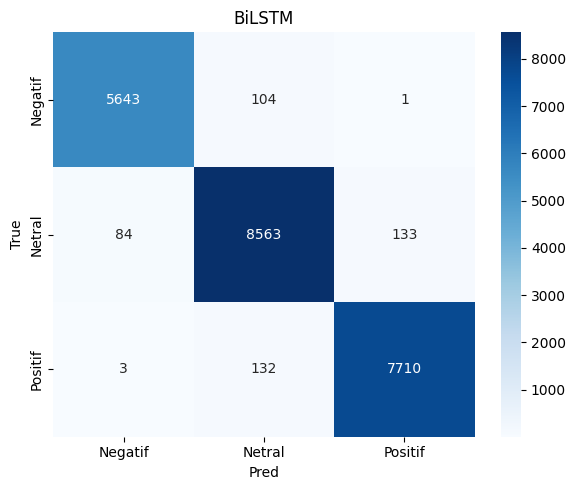

In [14]:
model1 = build_bilstm(vocab_size, MAX_LEN)
model1.fit(X_train_dl, y_train_dl, validation_split=0.2, epochs=20, batch_size=64,
           callbacks=make_callbacks("s1"), class_weight=class_weights_dict, verbose=1)
train_acc1 = accuracy_score(np.argmax(y_train_dl, 1), np.argmax(model1.predict(X_train_dl, verbose=0), 1))
y_pred1 = np.argmax(model1.predict(X_test_dl, verbose=0), 1)
y_true1 = np.argmax(y_test_dl, 1)
print(f"Train: {train_acc1:.4f}")
acc1 = evaluate(y_true1, y_pred1, "Scheme 1: BiLSTM")
plot_cm(y_true1, y_pred1, "BiLSTM")

## Scheme 2: CNN

Epoch 1/20


I0000 00:00:1769209089.971284     100 service.cc:152] XLA service 0x7f3dc508d4e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1769209089.971319     100 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1769209089.971322     100 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
2026-01-23 22:58:11.930981: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-23 22:58:12.161921: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-23 22:58:12.515515: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time

  31/1119  5s 5ms/step - accuracy: 0.3690 - loss: 1.0818

I0000 00:00:1769209094.920536     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1119/1119  16s 9ms/step - accuracy: 0.7144 - loss: 0.6210 - val_accuracy: 0.9446 - val_loss: 0.1641 - learning_rate: 2.0000e-04
Epoch 2/20
1119/1119  7s 6ms/step - accuracy: 0.9505 - loss: 0.1438 - val_accuracy: 0.9649 - val_loss: 0.1033 - learning_rate: 2.0000e-04
Epoch 3/20
1119/1119  7s 6ms/step - accuracy: 0.9736 - loss: 0.0816 - val_accuracy: 0.9691 - val_loss: 0.0841 - learning_rate: 2.0000e-04
Epoch 4/20
1119/1119  7s 6ms/step - accuracy: 0.9830 - loss: 0.0536 - val_accuracy: 0.9658 - val_loss: 0.0951 - learning_rate: 2.0000e-04
Epoch 5/20
1115/1119  0s 5ms/step - accuracy: 0.9878 - loss: 0.0396
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.
1119/1119  7s 6ms/step - accuracy: 0.9878 - loss: 0.0395 - val_accuracy: 0.9709 - val_loss: 0.0864 - learning_rate: 2.0000e-04
Epoch 6/20
1119/1119  6s 6ms/step - accuracy: 0.9925 - loss: 0.0270 - val_accuracy: 0.9703 - val_loss: 0.0971 - learning_rate: 1.0000e-04
Epoch 7/20
1110/1119  0s 5ms/step - accuracy: 0.9

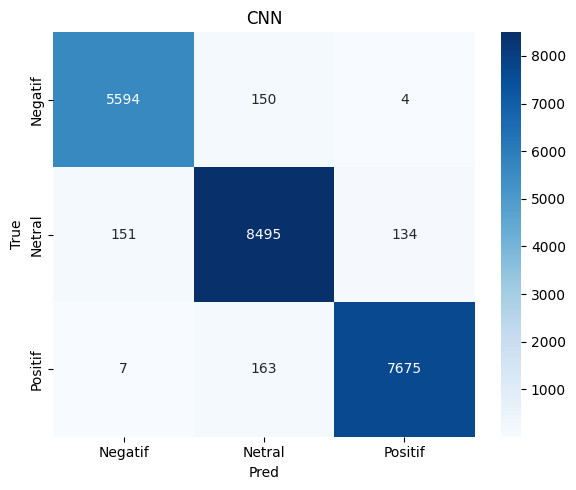

In [15]:
model2 = build_cnn(vocab_size, MAX_LEN)
model2.fit(X_train_dl, y_train_dl, validation_split=0.2, epochs=20, batch_size=64,
           callbacks=make_callbacks("s2"), class_weight=class_weights_dict, verbose=1)
train_acc2 = accuracy_score(np.argmax(y_train_dl, 1), np.argmax(model2.predict(X_train_dl, verbose=0), 1))
y_pred2 = np.argmax(model2.predict(X_test_dl, verbose=0), 1)
print(f"Train: {train_acc2:.4f}")
acc2 = evaluate(y_true1, y_pred2, "Scheme 2: CNN")
plot_cm(y_true1, y_pred2, "CNN")

## Scheme 3: Focal Loss

Epoch 1/20
1119/1119  22s 17ms/step - accuracy: 0.6883 - loss: 0.0699 - val_accuracy: 0.9279 - val_loss: 0.0224 - learning_rate: 2.0000e-04
Epoch 2/20
1119/1119  18s 16ms/step - accuracy: 0.9344 - loss: 0.0207 - val_accuracy: 0.9424 - val_loss: 0.0180 - learning_rate: 2.0000e-04
Epoch 3/20
1119/1119  18s 16ms/step - accuracy: 0.9555 - loss: 0.0152 - val_accuracy: 0.9497 - val_loss: 0.0159 - learning_rate: 2.0000e-04
Epoch 4/20
1119/1119  18s 16ms/step - accuracy: 0.9635 - loss: 0.0123 - val_accuracy: 0.9544 - val_loss: 0.0146 - learning_rate: 2.0000e-04
Epoch 5/20
1119/1119  18s 16ms/step - accuracy: 0.9698 - loss: 0.0095 - val_accuracy: 0.9566 - val_loss: 0.0137 - learning_rate: 2.0000e-04
Epoch 6/20
1119/1119  18s 16ms/step - accuracy: 0.9740 - loss: 0.0079 - val_accuracy: 0.9633 - val_loss: 0.0125 - learning_rate: 2.0000e-04
Epoch 7/20
1119/1119  18s 16ms/step - accuracy: 0.9795 - loss: 0.0062 - val_accuracy: 0.9632 - val_loss: 0.0126 - learning_rate: 2.0000e-04
Epoch 8/20
1119/1119

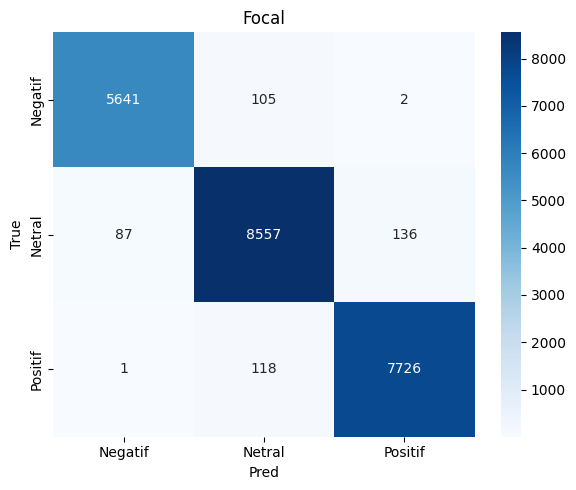

In [16]:
model3 = build_focal(vocab_size, MAX_LEN)
model3.fit(X_train_dl, y_train_dl, validation_split=0.2, epochs=20, batch_size=64,
           callbacks=make_callbacks("s3"), class_weight=class_weights_dict, verbose=1)
train_acc3 = accuracy_score(np.argmax(y_train_dl, 1), np.argmax(model3.predict(X_train_dl, verbose=0), 1))
y_pred3 = np.argmax(model3.predict(X_test_dl, verbose=0), 1)
print(f"Train: {train_acc3:.4f}")
acc3 = evaluate(y_true1, y_pred3, "Scheme 3: Focal")
plot_cm(y_true1, y_pred3, "Focal")

## Scheme 4: SVM

Train: 0.9910

Scheme 4: SVM - Acc: 0.9468 (94.68%)
              precision    recall  f1-score   support

     Negatif       0.94      0.94      0.94      8623
      Netral       0.93      0.95      0.94     13170
     Positif       0.97      0.95      0.96     11767

    accuracy                           0.95     33560
   macro avg       0.95      0.95      0.95     33560
weighted avg       0.95      0.95      0.95     33560



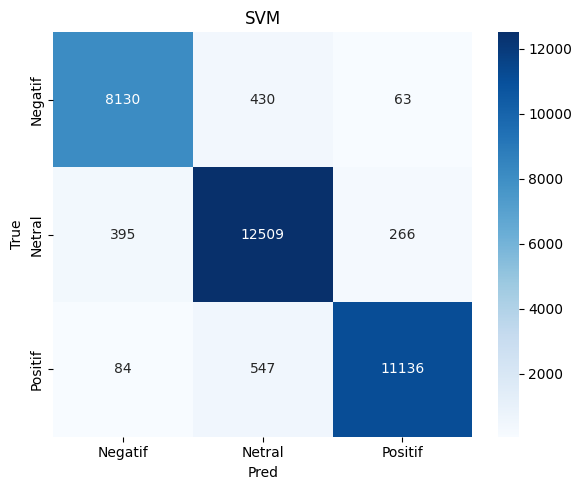

In [17]:
svm = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=SEED)
svm.fit(X_train_tfidf, y_train_ml)
train_acc4 = accuracy_score(y_train_ml, svm.predict(X_train_tfidf))
y_pred4 = svm.predict(X_test_tfidf)
print(f"Train: {train_acc4:.4f}")
acc4 = evaluate(y_test_ml, y_pred4, "Scheme 4: SVM")
plot_cm(y_test_ml, y_pred4, "SVM")

## Scheme 5: Random Forest

Train: 0.9999

Scheme 5: RF - Acc: 0.9170 (91.70%)
              precision    recall  f1-score   support

     Negatif       0.85      0.96      0.90      8623
      Netral       0.95      0.87      0.91     13170
     Positif       0.94      0.94      0.94     11767

    accuracy                           0.92     33560
   macro avg       0.91      0.92      0.92     33560
weighted avg       0.92      0.92      0.92     33560



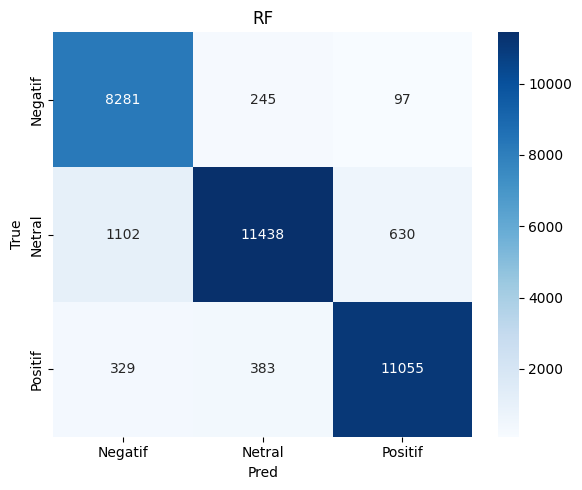

In [18]:
rf = RandomForestClassifier(n_estimators=200, random_state=SEED, n_jobs=-1)
rf.fit(X_train_tfidf, y_train_ml)
train_acc5 = accuracy_score(y_train_ml, rf.predict(X_train_tfidf))
y_pred5 = rf.predict(X_test_tfidf)
print(f"Train: {train_acc5:.4f}")
acc5 = evaluate(y_test_ml, y_pred5, "Scheme 5: RF")
plot_cm(y_test_ml, y_pred5, "RF")

## Scheme 6: Naive Bayes

Train: 0.8251

Scheme 6: NB - Acc: 0.7996 (79.96%)
              precision    recall  f1-score   support

     Negatif       0.78      0.81      0.79      8623
      Netral       0.76      0.78      0.77     13170
     Positif       0.87      0.81      0.84     11767

    accuracy                           0.80     33560
   macro avg       0.80      0.80      0.80     33560
weighted avg       0.80      0.80      0.80     33560



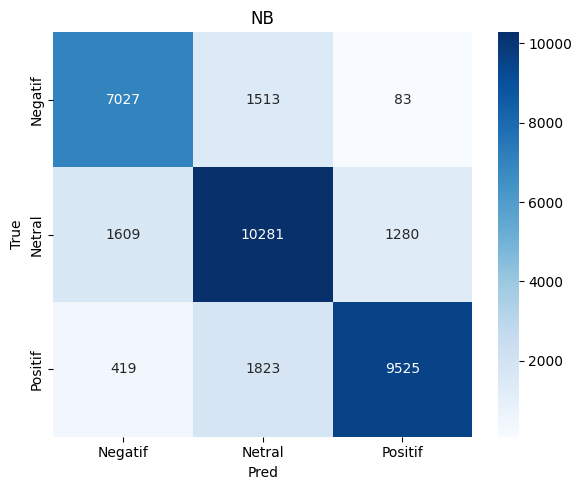

In [19]:
nb = MultinomialNB(alpha=1.0)
nb.fit(X_train_tfidf, y_train_ml)
train_acc6 = accuracy_score(y_train_ml, nb.predict(X_train_tfidf))
y_pred6 = nb.predict(X_test_tfidf)
print(f"Train: {train_acc6:.4f}")
acc6 = evaluate(y_test_ml, y_pred6, "Scheme 6: NB")
plot_cm(y_test_ml, y_pred6, "NB")

## Results

In [20]:
# Initialize all accuracies (if not trained)
if 'acc7' not in locals(): acc7, train_acc7 = 0.0, 0.0
if 'acc8' not in locals(): acc8, train_acc8 = 0.0, 0.0
if 'acc9' not in locals(): acc9, train_acc9 = 0.0, 0.0
if 'acc10' not in locals(): acc10, train_acc10 = 0.0, 0.0

results = pd.DataFrame({
    'Scheme': ['1. BiLSTM', '2. CNN', '3. Focal', '4. SVM', '5. RF', '6. NB', '7. IndoBERT'],
    'Train': [
        f"{train_acc1*100:.2f}%",
        f"{train_acc2*100:.2f}%",
        f"{train_acc3*100:.2f}%",
        f"{train_acc4*100:.2f}%",
        f"{train_acc5*100:.2f}%",
        f"{train_acc6*100:.2f}%",
        f"{train_acc7*100:.2f}%" if train_acc7 > 0 else "N/A"
    ],
    'Test': [
        f"{acc1*100:.2f}%",
        f"{acc2*100:.2f}%",
        f"{acc3*100:.2f}%",
        f"{acc4*100:.2f}%",
        f"{acc5*100:.2f}%",
        f"{acc6*100:.2f}%",
        f"{acc7*100:.2f}%" if acc7 > 0 else "N/A"
    ]
})

print("\n" + "="*80)
print("HASIL AKHIR")
print("="*80)
print(results.to_string(index=False))
print("="*80)

# Check core requirements (schemes 1-6)
core_accs = [acc1, acc2, acc3, acc4, acc5, acc6]
above_85 = sum([1 for a in core_accs if a >= 0.85])
above_92 = sum([1 for a in core_accs if a >= 0.92])

print(f"\n Skema 1-6:")
print(f"   Schemes ≥85%: {above_85}/6")
print(f"   Schemes ≥92%: {above_92}/6")

if above_85 >= 3:
    print("\n REQUIREMENT: ≥3 schemes with ≥85% accuracy")
if above_92 >= 1:
    print(" BONUS: ≥1 scheme with ≥92% accuracy")



HASIL AKHIR
     Scheme  Train   Test
  1. BiLSTM 99.61% 97.96%
     2. CNN 99.44% 97.28%
   3. Focal 99.57% 97.99%
     4. SVM 99.10% 94.68%
      5. RF 99.99% 91.70%
      6. NB 82.51% 79.96%
7. IndoBERT 97.08% 92.10%

 Skema 1-6:
   Schemes ≥85%: 5/6
   Schemes ≥92%: 4/6

 REQUIREMENT: ≥3 schemes with ≥85% accuracy
 BONUS: ≥1 scheme with ≥92% accuracy


## Inference Demo (All Schemes)

In [21]:
# Collect all models and their info
all_models = [
    (model1, "Scheme 1: BiLSTM", "dl", acc1),
    (model2, "Scheme 2: CNN", "dl", acc2),
    (model3, "Scheme 3: Focal", "dl", acc3),
    (svm, "Scheme 4: SVM", "ml", acc4),
    (rf, "Scheme 5: RF", "ml", acc5),
    (nb, "Scheme 6: NB", "ml", acc6),
]

# Add IndoBERT if trained
if 'model7' in locals() and acc7 > 0:
    all_models.append((model7, "Scheme 7: IndoBERT", "bert", acc7))

def predict_sentiment(text, model, model_type):
    """Predict sentiment for given text"""
    cleaned = clean_text(text)
    
    if model_type == "dl":
        # Deep learning models
        seq = tokenizer_dl.texts_to_sequences([cleaned])
        x = pad_sequences(seq, maxlen=MAX_LEN, padding="post")
        pred = model.predict(x, verbose=0)[0]
        label_idx = np.argmax(pred)
        confidence = pred
    elif model_type == "ml":
        # Traditional ML models
        x = tfidf.transform([cleaned])
        label_idx = model.predict(x)[0]
        if hasattr(model, 'predict_proba'):
            confidence = model.predict_proba(x)[0]
        else:
            confidence = None
    else:  # bert
        # BERT model (PyTorch)
        import torch
        enc = tokenizer7([cleaned], padding='max_length', truncation=True, 
                        max_length=128, return_tensors="pt")
        model.eval()
        with torch.no_grad():
            device = next(model.parameters()).device
            out = model(enc['input_ids'].to(device), 
                       attention_mask=enc['attention_mask'].to(device))
            probs = torch.softmax(out.logits, dim=1).cpu().numpy()[0]
            label_idx = np.argmax(probs)
            confidence = probs
    
    return label_map[label_idx], confidence

# Test samples
test_samples = [
    "aplikasi jelek banget, sering error dan lemot",
    "biasa aja sih, kadang bisa kadang ngga",
    "bagus, lancar, mantap buat chat",
    "sangat memuaskan, fitur lengkap dan mudah digunakan",
    "kecewa, uang sudah dipotong tapi pesanan tidak masuk",
    "standar saja, tidak ada yang istimewa",
    "aplikasi terbaik yang pernah saya coba!",
    "mengecewakan sekali, customer service tidak responsif",
]

print("\n" + "="*100)
print("DEMO INFERENSI")
print("="*100)

for sample_idx, text in enumerate(test_samples, 1):
    print(f"\n{'='*100}")
    print(f"Test {sample_idx}: {text}")
    print(f"{'='*100}")
    
    for model, name, mtype, test_acc in all_models:
        try:
            label, conf = predict_sentiment(text, model, mtype)
            conf_str = f"[Neg={conf[0]:.3f}, Net={conf[1]:.3f}, Pos={conf[2]:.3f}]" if conf is not None else ""
            print(f"   {name:25s} → {label:8s} {conf_str}")
        except Exception as e:
            print(f"   {name:25s} → Error: {e}")

print("\n" + "="*100)

# Find best model
best_idx = max(range(len(all_models)), key=lambda i: all_models[i][3])
best_model, best_name, best_type, best_acc = all_models[best_idx]

print(f"\n Model Terbaik: {best_name}")
print(f"   Test Accuracy: {best_acc*100:.2f}%")
print("="*100)



DEMO INFERENSI

Test 1: aplikasi jelek banget, sering error dan lemot
   Scheme 1: BiLSTM          → Negatif  [Neg=1.000, Net=0.000, Pos=0.000]
   Scheme 2: CNN             → Negatif  [Neg=1.000, Net=0.000, Pos=0.000]
   Scheme 3: Focal           → Negatif  [Neg=0.999, Net=0.001, Pos=0.000]
   Scheme 4: SVM             → Negatif  
   Scheme 5: RF              → Negatif  [Neg=0.950, Net=0.045, Pos=0.005]
   Scheme 6: NB              → Negatif  [Neg=0.961, Net=0.034, Pos=0.005]

Test 2: biasa aja sih, kadang bisa kadang ngga
   Scheme 1: BiLSTM          → Positif  [Neg=0.000, Net=0.000, Pos=1.000]
   Scheme 2: CNN             → Positif  [Neg=0.000, Net=0.000, Pos=1.000]
   Scheme 3: Focal           → Positif  [Neg=0.000, Net=0.021, Pos=0.979]
   Scheme 4: SVM             → Positif  
   Scheme 5: RF              → Positif  [Neg=0.055, Net=0.125, Pos=0.820]
   Scheme 6: NB              → Positif  [Neg=0.121, Net=0.238, Pos=0.641]

Test 3: bagus, lancar, mantap buat chat
   Scheme 1: BiLST

## Inference Demo - All Schemes

In [22]:
# Inference Demo - Test All Models
print("\n" + "="*80)
print("DEMO INFERENSI")
print("="*80)

test_samples = [
    "aplikasi jelek banget, sering error dan lemot",
    "biasa aja sih, kadang bisa kadang ngga",
    "bagus, lancar, mantap buat chat",
    "sangat memuaskan, fitur lengkap",
    "kecewa, uang dipotong tapi pesanan tidak masuk",
    "standar saja, tidak istimewa",
    "aplikasi terbaik yang pernah saya coba!",
    "mengecewakan, cs tidak responsif",
]

# Predict with all models
for i, text in enumerate(test_samples, 1):
    cleaned = clean_text(text)
    print(f"\n{'='*80}")
    print(f"Test {i}: {text}")
    print('-'*80)
    
    # Scheme 1: BiLSTM
    seq = tokenizer_dl.texts_to_sequences([cleaned])
    x_dl = pad_sequences(seq, maxlen=MAX_LEN, padding="post")
    pred1 = model1.predict(x_dl, verbose=0)[0]
    label1 = label_map[np.argmax(pred1)]
    print(f"1. BiLSTM      → {label1:8s} (N:{pred1[0]:.3f}, Ne:{pred1[1]:.3f}, P:{pred1[2]:.3f})")
    
    # Scheme 2: CNN
    pred2 = model2.predict(x_dl, verbose=0)[0]
    label2 = label_map[np.argmax(pred2)]
    print(f"2. CNN         → {label2:8s} (N:{pred2[0]:.3f}, Ne:{pred2[1]:.3f}, P:{pred2[2]:.3f})")
    
    # Scheme 3: Focal
    pred3 = model3.predict(x_dl, verbose=0)[0]
    label3 = label_map[np.argmax(pred3)]
    print(f"3. Focal       → {label3:8s} (N:{pred3[0]:.3f}, Ne:{pred3[1]:.3f}, P:{pred3[2]:.3f})")
    
    # Scheme 4: SVM
    x_ml = tfidf.transform([cleaned])
    label4 = label_map[svm.predict(x_ml)[0]]
    if hasattr(svm, 'predict_proba'):
        pred4 = svm.predict_proba(x_ml)[0]
        print(f"4. SVM         → {label4:8s} (N:{pred4[0]:.3f}, Ne:{pred4[1]:.3f}, P:{pred4[2]:.3f})")
    else:
        print(f"4. SVM         → {label4:8s}")
    
    # Scheme 5: Random Forest
    label5 = label_map[rf.predict(x_ml)[0]]
    pred5 = rf.predict_proba(x_ml)[0]
    print(f"5. RF          → {label5:8s} (N:{pred5[0]:.3f}, Ne:{pred5[1]:.3f}, P:{pred5[2]:.3f})")
    
    # Scheme 6: Naive Bayes
    label6 = label_map[nb.predict(x_ml)[0]]
    pred6 = nb.predict_proba(x_ml)[0]
    print(f"6. NB          → {label6:8s} (N:{pred6[0]:.3f}, Ne:{pred6[1]:.3f}, P:{pred6[2]:.3f})")
    
    # Scheme 7: IndoBERT (if trained)
    if 'model7' in locals():
        import torch
        enc7 = tokenizer7([cleaned], padding='max_length', truncation=True, max_length=128, return_tensors="pt")
        with torch.no_grad():
            out7 = model7(enc7['input_ids'].to(device), attention_mask=enc7['attention_mask'].to(device))
            pred7 = torch.softmax(out7.logits, dim=1)[0].cpu().numpy()
            label7 = label_map[np.argmax(pred7)]
        print(f"7. IndoBERT    → {label7:8s} (N:{pred7[0]:.3f}, Ne:{pred7[1]:.3f}, P:{pred7[2]:.3f})")
    else:
        print(f"7. IndoBERT    → Not trained (uncomment to test)")

print("\n" + "="*80)

# Voting ensemble (majority vote from all 6 core schemes)
print("\n" + "="*80)
print("PREDIKSI ENSEMBLE")
print("="*80)

for i, text in enumerate(test_samples, 1):
    cleaned = clean_text(text)
    
    # Get predictions from all models
    seq = tokenizer_dl.texts_to_sequences([cleaned])
    x_dl = pad_sequences(seq, maxlen=MAX_LEN, padding="post")
    x_ml = tfidf.transform([cleaned])
    
    votes = [
        np.argmax(model1.predict(x_dl, verbose=0)[0]),  # BiLSTM
        np.argmax(model2.predict(x_dl, verbose=0)[0]),  # CNN
        np.argmax(model3.predict(x_dl, verbose=0)[0]),  # Focal
        svm.predict(x_ml)[0],                            # SVM
        rf.predict(x_ml)[0],                             # RF
        nb.predict(x_ml)[0]                              # NB
    ]
    
    # Count votes
    from collections import Counter
    vote_counts = Counter(votes)
    ensemble_pred = vote_counts.most_common(1)[0][0]
    ensemble_label = label_map[ensemble_pred]
    
    # Show individual votes
    vote_labels = [label_map[v] for v in votes]
    print(f"\n{i}. {text}")
    print(f"   Votes: {vote_labels}")
    print(f"   → ENSEMBLE: {ensemble_label} ({vote_counts[ensemble_pred]}/6 votes)")

print("\n" + "="*80)



DEMO INFERENSI

Test 1: aplikasi jelek banget, sering error dan lemot
--------------------------------------------------------------------------------
1. BiLSTM      → Negatif  (N:1.000, Ne:0.000, P:0.000)
2. CNN         → Negatif  (N:1.000, Ne:0.000, P:0.000)
3. Focal       → Negatif  (N:0.999, Ne:0.001, P:0.000)
4. SVM         → Negatif 
5. RF          → Negatif  (N:0.950, Ne:0.045, P:0.005)
6. NB          → Negatif  (N:0.961, Ne:0.034, P:0.005)
7. IndoBERT    → Not trained (uncomment to test)

Test 2: biasa aja sih, kadang bisa kadang ngga
--------------------------------------------------------------------------------
1. BiLSTM      → Positif  (N:0.000, Ne:0.000, P:1.000)
2. CNN         → Positif  (N:0.000, Ne:0.000, P:1.000)
3. Focal       → Positif  (N:0.000, Ne:0.021, P:0.979)
4. SVM         → Positif 
5. RF          → Positif  (N:0.055, Ne:0.125, P:0.820)
6. NB          → Positif  (N:0.121, Ne:0.238, P:0.641)
7. IndoBERT    → Not trained (uncomment to test)

Test 3: bagus, lan

## Save

In [23]:
# Collect all models with their accuracies
all_models_info = [
    (model1, 'BiLSTM', 'dl', acc1, train_acc1),
    (model2, 'CNN', 'dl', acc2, train_acc2),
    (model3, 'Focal', 'dl', acc3, train_acc3),
    (svm, 'SVM', 'ml', acc4, train_acc4),
    (rf, 'RF', 'ml', acc5, train_acc5),
    (nb, 'NB', 'ml', acc6, train_acc6),
]

# Add IndoBERT if trained
if 'model7' in locals() and acc7 > 0:
    all_models_info.append((model7, 'IndoBERT', 'bert', acc7, train_acc7))

# Find best model
best_idx = max(range(len(all_models_info)), key=lambda i: all_models_info[i][3])
best_model, best_name, best_type, best_acc, best_train = all_models_info[best_idx]

print(f"\n{'='*80}")
print(f"SAVING Model Terbaik: {best_name}")
print(f"Train Accuracy: {best_train*100:.2f}%")
print(f"Test Accuracy: {best_acc*100:.2f}%")
print(f"{'='*80}")

# Save model
if best_type == 'dl':
    best_model.save('best_model.keras')
    with open('tokenizer.pkl', 'wb') as f:
        pickle.dump(tokenizer_dl, f)
    print(" Saved: best_model.keras, tokenizer.pkl")
elif best_type == 'ml':
    with open('best_model.pkl', 'wb') as f:
        pickle.dump(best_model, f)
    with open('tfidf.pkl', 'wb') as f:
        pickle.dump(tfidf, f)
    print(" Saved: best_model.pkl, tfidf.pkl")
else:  # bert
    import torch
    torch.save(best_model.state_dict(), 'best_model_bert.pt')
    tokenizer7.save_pretrained('bert_tokenizer')
    print(" Saved: best_model_bert.pt, bert_tokenizer/")

# Save config
config = {
    'best_model': best_name,
    'model_type': best_type,
    'train_accuracy': float(best_train),
    'test_accuracy': float(best_acc),
    'label_map': label_map,
    'all_results': {
        f'scheme_{i+1}': {
            'name': name,
            'train_acc': float(train),
            'test_acc': float(test)
        }
        for i, (_, name, _, test, train) in enumerate(all_models_info)
    }
}

with open('model_config.json', 'w') as f:
    json.dump(config, f, indent=2)
print(" Saved: model_config.json")

# Save results table
results.to_csv('results_summary.csv', index=False)
print(" Saved: results_summary.csv")

print(f"\n{'='*80}")
print(" SEMUA FILE TERSIMPAN")
print(f"{'='*80}\n")



SAVING Model Terbaik: Focal
Train Accuracy: 99.57%
Test Accuracy: 97.99%
 Saved: best_model.keras, tokenizer.pkl
 Saved: model_config.json
 Saved: results_summary.csv

 SEMUA FILE TERSIMPAN

